# Introduction

LSTMを用いた深層学習について、  
複数の時系列データで、各時系列データが複数属性を持つデータを扱う。


# ライブラリの読み込み

In [1]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed

# データの作成

データ数は6, 各データは3次元

In [2]:
def make_random_data(length=100):
    yRange = 100
    zRange = 10

    y = 1.0 + np.random.choice(yRange, length)
    z = 1.0 + np.random.choice(zRange, length)
    x = np.random.rand(length)

    # xの値がy, zで決定される
    for t in range(3, length):
        x[t]  = y[t-1] * z[t-2] + y[t-2] + z[t-1]

    data = np.vstack([x, y, z]).swapaxes(0, 1)
    return data

def generate_data(num=6):
    data = []
    for idx in range(num):
        data.append(make_random_data(100))
    return np.array(data)

data = generate_data(6)
print(data.shape)

(6, 100, 3)


In [3]:
def show_graph(data, label, color="b"):
    plt.figure(figsize=(14, 8))
    plt.subplot(211)
    plt.xlabel('time')
    plt.ylabel('value')
    plt.plot(range(len(data)), data, color=color, label=label)
    plt.legend(loc='upper right')
    plt.show()

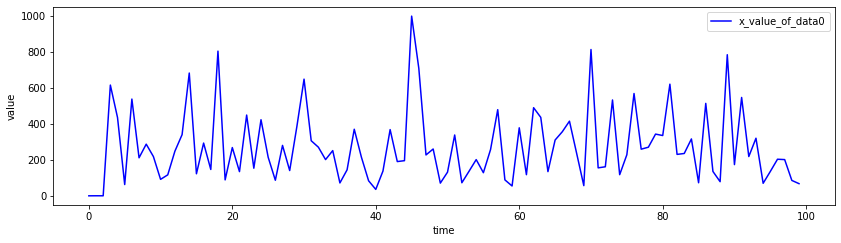

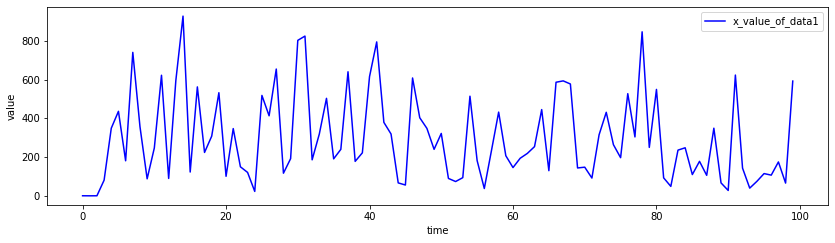

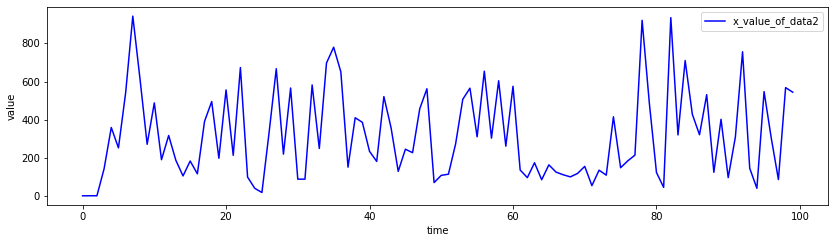

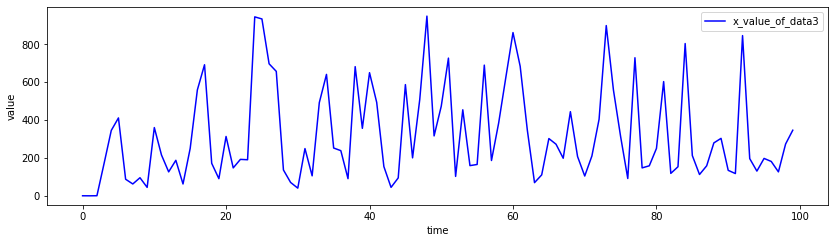

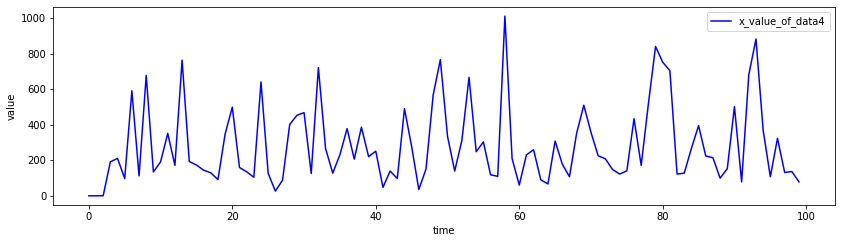

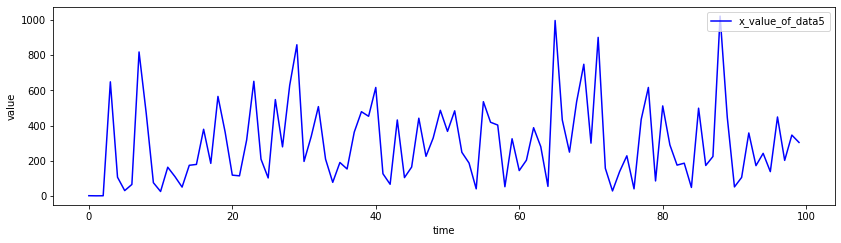

In [4]:
for idx in range(len(data)):
    show_graph(data[idx, :, 0], 'x_value_of_data{}'.format(idx))

# データの分割
- 学習データ (前半70%)
- テストデータ (残り後半30%)

In [5]:
train_rate = 0.7
data_length = data.shape[1]
train_size = int(data_length * train_rate)
X_train, X_test = data[:, :train_size, :], data[:, train_size:, :]
Y_train, Y_test = X_train[:, :, 0:1], X_test[:, :, 0:1]
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(6, 70, 3)
(6, 30, 3)
(6, 70, 1)
(6, 30, 1)


# 前処理
- データのスケーリング
- LSTMのインプットデータに整形

In [6]:
# スケーリング
def transform_data(data: np.array, inverse_option: bool, scaler: object):
    # x, y, zのそれぞれでスケーリング
    orig_shape = data.shape
    data = data.reshape(-1, data.shape[-1])
    if inverse_option is True:
        data = scaler.inverse_transform(data)
    else:
        data = scaler.fit_transform(data)
    return data.reshape(orig_shape)

X_scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaling = transform_data(X_train, inverse_option=False, scaler=X_scaler)
X_test_scaling = transform_data(X_test, inverse_option=False, scaler=X_scaler)

Y_scaler = MinMaxScaler(feature_range=(0, 1))
Y_train_scaling = transform_data(Y_train, inverse_option=False, scaler=Y_scaler)

In [7]:
print(X_train_scaling.shape)
print(X_test_scaling.shape)
print(Y_train_scaling.shape)

(6, 70, 3)
(6, 30, 3)
(6, 70, 1)


In [8]:
# LSTMのインプットデータへ整形
def create_dataset(data, batch_size, length):
    if data.shape[0] % batch_size != 0:
        raise ValueError('バッチサイズが不正です。')
    else:
        batch_num = data.shape[0] / batch_size

    if data.shape[1] % length != 0:
        raise ValueError('レングスが不正です。')
    else:
        split_num = data.shape[1] / length

    batch_list = np.split(data, batch_num, axis=0)
    split_list = [np.concatenate(np.split(batch, split_num, axis=1)) for batch in batch_list]
    data = np.concatenate(split_list)
    
    return data

batch_size = 2
data_length = 10
X_train_dataset = create_dataset(X_train_scaling, batch_size, data_length)
Y_train_dataset = create_dataset(Y_train_scaling, batch_size, data_length)
X_test_dataset = create_dataset(X_test_scaling, batch_size, data_length)

In [9]:
print(X_train_dataset.shape)
print(X_test_dataset.shape)
print(Y_train_dataset.shape)

(42, 10, 3)
(18, 10, 3)
(42, 10, 1)


# モデル作成

In [10]:
def create_model(batch_size, input_dim, output_dim, hidden_neurons, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(hidden_neurons, batch_input_shape=(batch_size, None, input_dim), return_sequences=True, stateful=True))
    model.add(TimeDistributed(Dense(output_dim, activation='linear')))
    print(model.summary())

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])
    return model

input_dim = X_train_dataset.shape[2]
output_dim = Y_train_dataset.shape[2]
hidden_neurons = 20
model = create_model(batch_size,
                     input_dim, 
                     output_dim,
                     hidden_neurons)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (2, None, 20)             1920      
_________________________________________________________________
time_distributed (TimeDistri (None, None, 1)           21        
Total params: 1,941
Trainable params: 1,941
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
epochs = 100
history = model.fit(X_train_dataset, Y_train_dataset, batch_size=batch_size, epochs=epochs)

Epoch 1/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0473 - mse: 0.0473
Epoch 2/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0395 - mse: 0.0395
Epoch 3/100
21/21 [==============================] - 0s 1ms/step - loss: 0.0367 - mse: 0.0367
Epoch 4/100
21/21 [==============================] - 0s 1ms/step - loss: 0.0323 - mse: 0.0323
Epoch 5/100
21/21 [==============================] - 0s 1ms/step - loss: 0.0298 - mse: 0.0298
Epoch 6/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0258 - mse: 0.0258
Epoch 7/100
21/21 [==============================] - 0s 1ms/step - loss: 0.0230 - mse: 0.0230
Epoch 8/100
21/21 [==============================] - 0s 1ms/step - loss: 0.0182 - mse: 0.0182
Epoch 9/100
21/21 [==============================] - 0s 1ms/step - loss: 0.0134 - mse: 0.0134
Epoch 10/100
21/21 [==============================] - 0s 1ms/step - loss: 0.0088 - mse: 0.0088
Epoch 11/100
21/21 [==============================] - 0s 2m

21/21 [==============================] - 0s 1ms/step - loss: 2.2644e-05 - mse: 2.2644e-05
Epoch 82/100
21/21 [==============================] - 0s 1ms/step - loss: 2.0152e-05 - mse: 2.0152e-05
Epoch 83/100
21/21 [==============================] - 0s 1ms/step - loss: 2.5379e-05 - mse: 2.5379e-05
Epoch 84/100
21/21 [==============================] - 0s 1ms/step - loss: 2.4097e-05 - mse: 2.4097e-05
Epoch 85/100
21/21 [==============================] - 0s 1ms/step - loss: 2.1468e-05 - mse: 2.1468e-05
Epoch 86/100
21/21 [==============================] - 0s 1ms/step - loss: 2.0912e-05 - mse: 2.0912e-05
Epoch 87/100
21/21 [==============================] - 0s 1ms/step - loss: 3.0931e-05 - mse: 3.0931e-05
Epoch 88/100
21/21 [==============================] - 0s 1ms/step - loss: 2.4041e-05 - mse: 2.4041e-05
Epoch 89/100
21/21 [==============================] - 0s 1ms/step - loss: 1.9170e-05 - mse: 1.9170e-05
Epoch 90/100
21/21 [==============================] - 0s 1ms/step - loss: 2.1555e-05 -

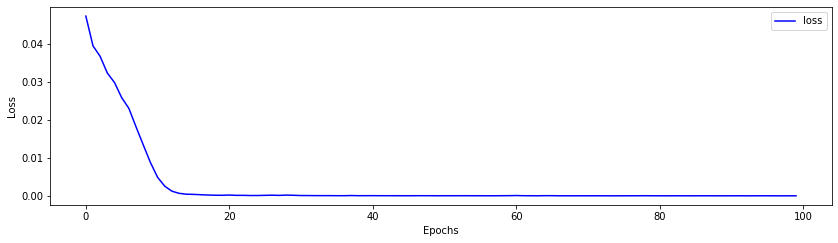

In [12]:
def show_history(history, color="b"):
    plt.figure(figsize=(14, 8))
    plt.subplot(211)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(history.history['loss'], color=color, label='loss')
    plt.legend(loc='upper right')
    plt.show()

show_history(history)

# テストデータ検証

In [13]:
pred_test = model.predict(X_test_dataset, batch_size=batch_size)
print(pred_test.shape)

(18, 10, 1)


In [14]:
def reshape_dataset(data, batch_size, org_shape):
    length = data.shape[1]

    # 一度連続で同型のデータでcreate_datasetを実行し、データ順序を調べる
    tmp = np.array(range(data.shape[0] * data.shape[1] * data.shape[2])).reshape(org_shape)
    sample = create_dataset(tmp, batch_size, length)
    order = np.argsort(sample[:, 0, 0])

    data = data[order, :, :].reshape(org_shape)
    return data

target_shape = X_test_scaling.shape[:2] + (1,)
Y_pred_test_scaling = reshape_dataset(pred_test, batch_size, target_shape)
print(Y_pred_test_scaling.shape)

(6, 30, 1)


In [15]:
Y_pred_test = transform_data(Y_pred_test_scaling, inverse_option=True, scaler=Y_scaler)

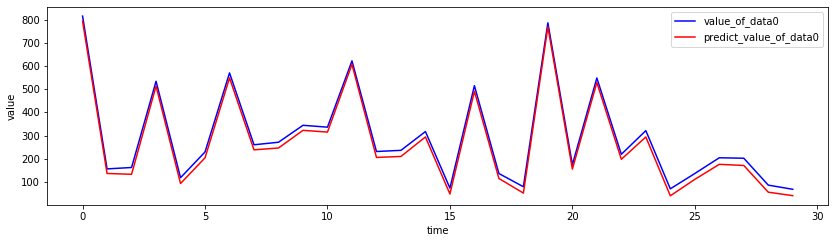

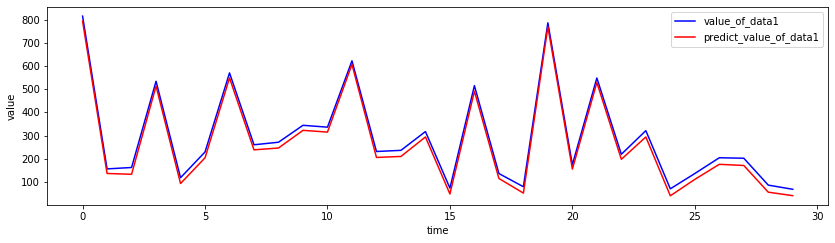

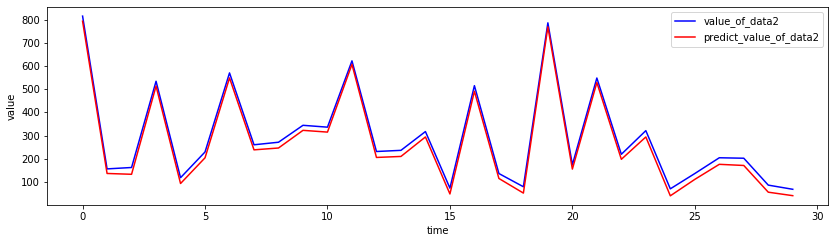

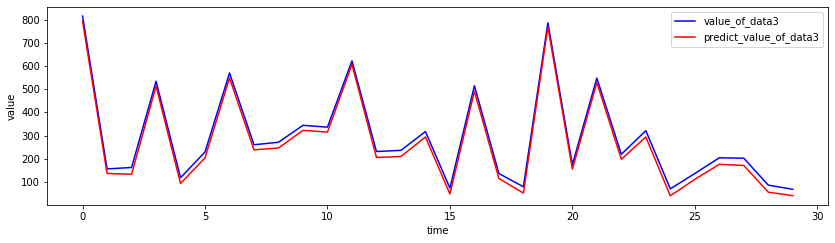

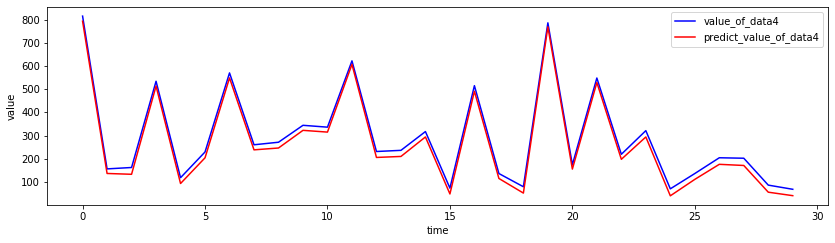

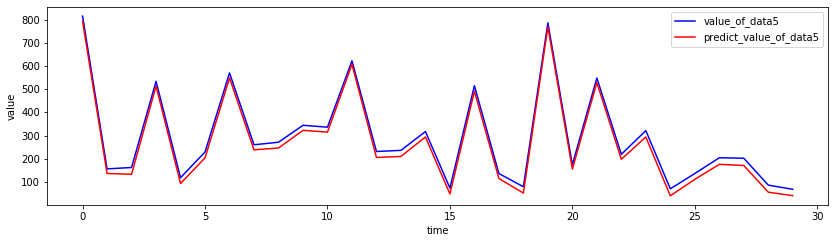

In [16]:
def show_graph_for_two_data(data1, data2, label1, label2, color1="b", color2="r"):
    plt.figure(figsize=(14, 8))
    plt.subplot(211)
    plt.xlabel('time')
    plt.ylabel('value')
    plt.plot(range(len(data1)), data1, color=color1, label=label1)
    plt.plot(range(len(data2)), data2, color=color2, label=label2)
    plt.legend(loc='upper right')
    plt.show()

for idx in range(len(Y_test)):
    show_graph_for_two_data(Y_test[0, :, 0], Y_pred_test[0, :, 0], 'value_of_data{}'.format(idx), 'predict_value_of_data{}'.format(idx))